Import Libraries

In [10]:
# Data manipulation
import pandas as pd
import numpy as np

# Tensorflow
import tensorflow as tf
config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(allow_growth=True))
sess = tf.compat.v1.Session(config=config)
import tensorflow_hub as hub
from tensorflow import keras

# Keras
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Model
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Conv2D,Dropout

# ResNet
from keras.applications.resnet50 import ResNet50

from sklearn.model_selection import train_test_split
from IPython.display import display, Image

# Data visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread

import os
import re

Checking TensorFlow version and GPU Compatability

In [11]:
print("TF version:", tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

TF version: 2.4.1
Num GPUs: 1


In [12]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Import Labels

In [13]:
labels = pd.read_csv("labels.csv")
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


Checking and we see that there are no empty data

In [14]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


Total number of unique dog breeds

In [15]:
unique_breeds = labels['breed'].unique().shape[0]
print("Unique breeds:", unique_breeds)

Unique breeds: 120


In [16]:
labels['id'] = labels['id'] + '.jpg'

Here we split our labels data into training and validation set

In [17]:
train, val = train_test_split(labels, test_size=0.2, shuffle=True)

In [18]:
print("Train shape:", train.shape)
print("Validation shape:", val.shape)

Train shape: (8177, 2)
Validation shape: (2045, 2)


Image data augmentation


We "create" more training data from existing data by doing image manipulation (Rotate/Zoom/Scaling/Contrast) (Get more variants of image for neural network to learn)

This will help improve the performance of the neural network

For more info: https://towardsdatascience.com/complete-image-augmentation-in-opencv-31a6b02694f5

In [19]:
# Datagen 

train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255, # Scale/Normalize pixel value from range [0,255] to [0,1], RGB coeff in 0-255 too high for model to process
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1/255.)


Retrieve our training/val/test sets

In [29]:
# Training / Validation set

bs = 64

training_set = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory='train/',
    x_col="id",
    y_col="breed",
    target_size=(224, 224), # Size of each image = 150x150, has to match input_shape
    class_mode="categorical",
    batch_size=bs
)

validation_set = validation_datagen.flow_from_dataframe(
    dataframe=val,
    directory='train/',
    x_col="id",
    y_col="breed",
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=bs
)

test_set = test_datagen.flow_from_directory(
    '',
    target_size = (224, 224),
    batch_size = bs,
    classes=['test']
)

Found 8177 validated image filenames belonging to 120 classes.
Found 2045 validated image filenames belonging to 120 classes.
Found 10357 images belonging to 1 classes.


1. CNN (Convolutional Neural Network)

In [30]:
input_shape = (224, 224, 3)

In [31]:
# Create a sequential model
inputs = keras.Input(shape=input_shape)

x = Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[224, 224, 3])(inputs)
x = MaxPooling2D(pool_size=2, strides=2)(x)

x = Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = MaxPooling2D(pool_size=2, strides=2)(x)

x = Flatten()(x)
x = Dense(units=64, activation='relu')(x)

predictions = Dense(units=unique_breeds, activation='softmax')(x) # Classification layer

cnn = keras.Model(inputs, predictions, name='CNN')

cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])


View summary of the CNN model

In [32]:
cnn.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 93312)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                5972032 

In [33]:
model_plot = tf.keras.utils.plot_model(cnn, show_shapes=True)
display(model_plot)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


None

Checkpoints

In [34]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join('models/', 'cnn_best_val_loss2.h5'),
    save_weights_only=False,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

# If the validation loss doesn't improve, stop training
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=9)

# If the validation loss doesn't improve, reduce the learning rate to 0.2 times it's previous value

# New LR = Old LR * factor
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=3)

Training the CNN model

In [35]:
epochs = 1

step_size_train = training_set.n // bs
step_size_val = validation_set.n // bs

In [36]:
# Samples // batch size = # of batches
# 1 epoch trains # of batches
# Weights updated after each batch 

history = cnn.fit(training_set,
          epochs=epochs,
          steps_per_epoch=step_size_train,
          validation_data=validation_set,
          validation_steps=step_size_val,
          callbacks=[model_checkpoint, earlystopping, reduce_lr], shuffle=True, verbose=1)

127/127 [==============================] - 98s 755ms/step - loss: 5.1380 - accuracy: 0.0076 - val_loss: 4.7868 - val_accuracy: 0.0121


Save final CNN model

In [42]:
cnn.save('models/final_cnn.h5')

Model Evaluation

In [47]:
# Loss - Accuracy 

print(cnn.metrics_names)
cnn.evaluate(validation_set, steps=step_size_val, verbose=1)

['loss', 'accuracy']
31/31 [==============================] - 5s 175ms/step - loss: 4.7861 - accuracy: 0.0121


[4.786128044128418, 0.012096773833036423]

Accuracy + Loss plot

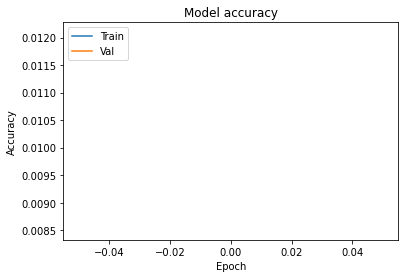

In [48]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

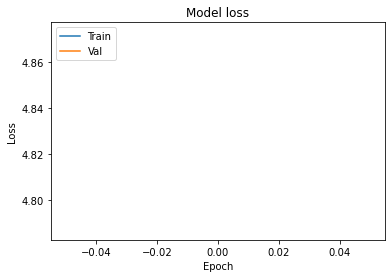

In [49]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Prediction on test set

In [51]:
cnn_y_pred = cnn.predict(test_set, verbose=1)

162/162 [==============================] - 27s 168ms/step


2. ResNet50 (Residual Network)

Tackling vanishing gradient

Using pre-trained ResNet model in keras (Transfer Learning)

In [55]:
# Set include_top=False, as we will be using our own classification layer
# Using imagenet weights

resnet = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)

Building classification layer on top of ResNet

In [66]:
inputs2 = keras.Input(shape=input_shape)

x = resnet(inputs2)

x = Flatten()(x)
x = Dropout(0.25)(x) # Dropout layer reduces overfitting

x = Dense(units=256,activation='relu')(x) # Rectified Linear Unit - Helping vanishing gradient
x = Dropout(0.25)(x)

x = Dense(units=128,activation='relu')(x)
x = Dropout(0.35)(x)

predictions2 = Dense(units=unique_breeds, activation='softmax')(x) # Sum of Prob = 1 

resnet = keras.Model(inputs2, predictions2, name='ResNet')

resnet.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) # Multi-class, Labels in one-hot, use categorical_crossentropy

View Summary of the ResNet model

In [68]:
resnet.summary()

Model: "ResNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
ResNet (Functional)          (None, 120)               49405808  
_________________________________________________________________
flatten_6 (Flatten)          (None, 120)               0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 120)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               30976     
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               32896

In [70]:
model_plot = tf.keras.utils.plot_model(cnn, show_shapes=True)
display(model_plot)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


None

Checkpoints

In [71]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join('models/', 'resnet_best_val_loss2.h5'),
    save_weights_only=False,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

# If the validation loss doesn't improve, stop training
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=9)

# If the validation loss doesn't improve, reduce the learning rate to 0.2 times it's previous value

# New LR = Old LR * factor
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=3)

Training the ResNet model

In [72]:
epochs = 1

In [73]:
history2 = cnn.fit(training_set,
          epochs=epochs,
          steps_per_epoch=step_size_train,
          validation_data=validation_set,
          validation_steps=step_size_val,
          callbacks=[model_checkpoint, earlystopping, reduce_lr], shuffle=True, verbose=1)

127/127 [==============================] - 93s 733ms/step - loss: 4.7765 - accuracy: 0.0134 - val_loss: 4.7498 - val_accuracy: 0.0212


Save final ResNet model

In [74]:
resnet.save('models/final_resnet.h5')

Model Evaluation

In [75]:
print(resnet.metrics_names)
resnet.evaluate(validation_set, steps=step_size_val, verbose=1)

[]
31/31 [==============================] - 12s 233ms/step - loss: 4.7874 - accuracy: 0.0097


[4.787292003631592, 0.009576613083481789]

Accuracy + Loss Plot

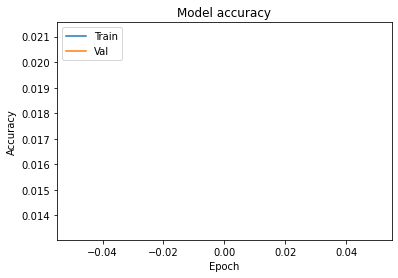

In [76]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

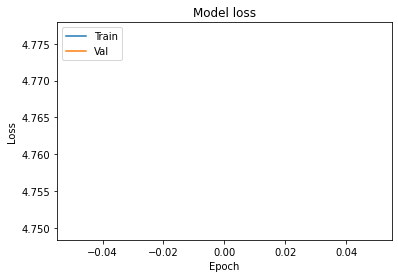

In [77]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Prediction on test set

In [78]:
resnet_y_pred = resnet.predict(test_set, verbose=1)

162/162 [==============================] - 41s 250ms/step


Comparison of models

In [ ]:
print("CNN:Loss vs Accuracy\n")
cnn.evaluate(validation_set, steps=step_size_val, verbose=1)
print("\n")
print("ResNet:Loss vs Accuracy\n")
resnet.evaluate(validation_set, steps=step_size_val, verbose=1)

Submission, opening the sample file to see requirements

In [16]:
sample = pd.read_csv('sample_submission.csv')
sample

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
4,001a5f3114548acdefa3d4da05474c2e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10352,ffeda8623d4eee33c6d1156a2ecbfcf8,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
10353,fff1ec9e6e413275984966f745a313b0,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
10354,fff74b59b758bbbf13a5793182a9bbe4,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
10355,fff7d50d848e8014ac1e9172dc6762a3,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


Get list of filenames

In [17]:
file_list = test_set.filenames
id_list = []
for name in file_list:
    m = re.sub('test/', '', name)
    m = re.sub('.jpg', '', m)
    id_list.append(m)

Map each prediction value to its respective class for each image/file

In [18]:
sample['id'] = id_list
sample.iloc[:,1:] = cnn_y_pred
sample

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,test\000621fb3cbb32d8935728e48679680e,0.008296,0.008430,0.008291,0.008540,0.008305,0.008219,0.008398,0.008520,0.008335,...,0.008342,0.008204,0.008255,0.008137,0.008358,0.008410,0.008321,0.008430,0.008274,0.008275
1,test\00102ee9d8eb90812350685311fe5890,0.008297,0.008430,0.008290,0.008541,0.008306,0.008220,0.008398,0.008522,0.008335,...,0.008342,0.008204,0.008256,0.008136,0.008358,0.008411,0.008321,0.008430,0.008274,0.008275
2,test\0012a730dfa437f5f3613fb75efcd4ce,0.008792,0.008371,0.007600,0.008942,0.008363,0.008779,0.008613,0.009327,0.008196,...,0.008250,0.008101,0.009005,0.007757,0.008543,0.008762,0.008315,0.008232,0.008517,0.007954
3,test\001510bc8570bbeee98c8d80c8a95ec1,0.008254,0.008443,0.008329,0.008498,0.008297,0.008193,0.008399,0.008473,0.008332,...,0.008351,0.008231,0.008209,0.008175,0.008337,0.008388,0.008313,0.008448,0.008263,0.008292
4,test\001a5f3114548acdefa3d4da05474c2e,0.008373,0.008407,0.008222,0.008617,0.008320,0.008267,0.008396,0.008608,0.008338,...,0.008325,0.008155,0.008339,0.008068,0.008395,0.008450,0.008334,0.008398,0.008294,0.008244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10352,test\ffeda8623d4eee33c6d1156a2ecbfcf8,0.008393,0.008400,0.008204,0.008638,0.008324,0.008280,0.008396,0.008632,0.008339,...,0.008321,0.008142,0.008361,0.008049,0.008405,0.008461,0.008338,0.008390,0.008299,0.008236
10353,test\fff1ec9e6e413275984966f745a313b0,0.008254,0.008443,0.008329,0.008498,0.008297,0.008193,0.008399,0.008473,0.008332,...,0.008351,0.008231,0.008209,0.008175,0.008337,0.008388,0.008313,0.008448,0.008263,0.008292
10354,test\fff74b59b758bbbf13a5793182a9bbe4,0.008377,0.008405,0.008219,0.008621,0.008321,0.008269,0.008396,0.008613,0.008338,...,0.008324,0.008153,0.008343,0.008064,0.008397,0.008452,0.008335,0.008397,0.008295,0.008243
10355,test\fff7d50d848e8014ac1e9172dc6762a3,0.008506,0.008366,0.008105,0.008751,0.008344,0.008349,0.008393,0.008760,0.008344,...,0.008296,0.008070,0.008484,0.007949,0.008458,0.008520,0.008357,0.008343,0.008327,0.008191


Output to csv

In [19]:
submission = sample.set_index('id')
submission.to_csv('submission.csv')

In [20]:
submission.head()

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
id,,,,,,,,,,,,,,,,,,,,,
test\000621fb3cbb32d8935728e48679680e,0.008296,0.008430,0.008291,0.008540,0.008305,0.008219,0.008398,0.008520,0.008335,0.008477,...,0.008342,0.008204,0.008255,0.008137,0.008358,0.008410,0.008321,0.008430,0.008274,0.008275
test\00102ee9d8eb90812350685311fe5890,0.008297,0.008430,0.008290,0.008541,0.008306,0.008220,0.008398,0.008522,0.008335,0.008478,...,0.008342,0.008204,0.008256,0.008136,0.008358,0.008411,0.008321,0.008430,0.008274,0.008275
test\0012a730dfa437f5f3613fb75efcd4ce,0.008792,0.008371,0.007600,0.008942,0.008363,0.008779,0.008613,0.009327,0.008196,0.009017,...,0.008250,0.008101,0.009005,0.007757,0.008543,0.008762,0.008315,0.008232,0.008517,0.007954
test\001510bc8570bbeee98c8d80c8a95ec1,0.008254,0.008443,0.008329,0.008498,0.008297,0.008193,0.008399,0.008473,0.008332,0.008440,...,0.008351,0.008231,0.008209,0.008175,0.008337,0.008388,0.008313,0.008448,0.008263,0.008292
test\001a5f3114548acdefa3d4da05474c2e,0.008373,0.008407,0.008222,0.008617,0.008320,0.008267,0.008396,0.008608,0.008338,0.008545,...,0.008325,0.008155,0.008339,0.008068,0.008395,0.008450,0.008334,0.008398,0.008294,0.008244


References

[1] https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/

[2] https://medium.com/@14prakash/understanding-and-implementing-architectures-of-resnet-and-resnext-for-state-of-the-art-image-cf51669e1624

[3] https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/#:~:text=The%20rectified%20linear%20activation%20function,otherwise%2C%20it%20will%20output%20zero.&text=The%20rectified%20linear%20activation%20function%20overcomes%20the%20vanishing%20gradient%20problem,learn%20faster%20and%20perform%20better.